## Boulder Watershed Demo

Process ATL03 data from the Boulder Watershed region and produce a customized ATL06 elevation dataset.

### What is demonstrated

* The `icesat2.atl06p` API is used to perform a SlideRule parallel processing request of the Boulder Watershed region
* The `matplotlib` and `cartopy` packages are used to plot the data returned by SlideRule

### Points of interest

This is a simple notebook showing how a region of interest can be processed by SlideRule and the results analyzed using pandas DataFrames and Matplotlib.

In [1]:
import sys
import logging
import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import time
from sliderule import icesat2

## SlideRule Configuration

In [2]:
# Configure ICESat-2 API
icesat2.init("icesat2sliderule.org", False)
# Configure Region of Interest
region = [ {"lon":-105.82971551223244, "lat": 39.81983728534918},
           {"lon":-105.30742121965137, "lat": 39.81983728534918},
           {"lon":-105.30742121965137, "lat": 40.164048017973755},
           {"lon":-105.82971551223244, "lat": 40.164048017973755},
           {"lon":-105.82971551223244, "lat": 39.81983728534918} ]

## Execute ATL06 Algorithm using SlideRule

In [6]:
# Latch Start Time
perf_start = time.perf_counter()

# Build ATL06 Request
parms = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 10.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
    "maxi": 1
}

# Request ATL06 Data
gdf = icesat2.atl06p(parms, "atlas-s3", version='003')

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time". format(perf_duration))
print("Reference Ground Tracks: {}".format(gdf["rgt"].unique()))
print("Cycles: {}".format(gdf["cycle"].unique()))
print("Received {} elevations".format(len(gdf)))

Completed in 39.029 seconds of wall-clock time
Reference Ground Tracks: [973  28 554 996  51]
Cycles: [1 2 3 4 5 6 7 8 9]
Received 113980 elevations


## Plot Region

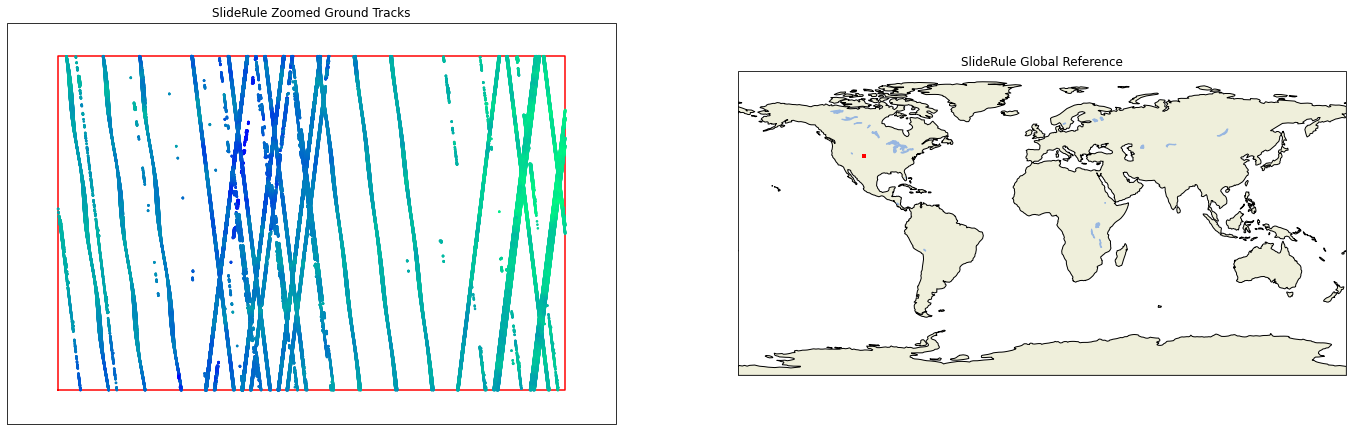

In [9]:
# Calculate Extent
lons = [p["lon"] for p in region]
lats = [p["lat"] for p in region]
lon_margin = (max(lons) - min(lons)) * 0.1
lat_margin = (max(lats) - min(lats)) * 0.1
extent = (min(lons) - lon_margin, max(lons) + lon_margin, min(lats) - lat_margin, max(lats) + lat_margin)

# Create Plot
fig = plt.figure(num=None, figsize=(24, 12))
box_lon = [e["lon"] for e in region]
box_lat = [e["lat"] for e in region]

# Plot SlideRule Ground Tracks
ax1 = plt.subplot(121,projection=cartopy.crs.PlateCarree())
ax1.set_title("SlideRule Zoomed Ground Tracks")
ax1.scatter(gdf.geometry.x, gdf.geometry.y, s=2.5, c=gdf["h_mean"], cmap='winter_r', zorder=3, transform=cartopy.crs.PlateCarree())
ax1.set_extent(extent,crs=cartopy.crs.PlateCarree())
ax1.plot(box_lon, box_lat, linewidth=1.5, color='r', zorder=2, transform=cartopy.crs.Geodetic())

# Plot SlideRule Global View
ax2 = plt.subplot(122,projection=cartopy.crs.PlateCarree())
ax2.set_title("SlideRule Global Reference")
#gdf.plot(kind='scatter', ax=ax2, x="lon", y="lat", s=2.5, c='r', zorder=3)
ax2.scatter(gdf.geometry.x, gdf.geometry.y, s=2.5, c='r', zorder=3, transform=cartopy.crs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax2.add_feature(cartopy.feature.LAKES)
ax2.set_extent((-180,180,-90,90),crs=cartopy.crs.PlateCarree())

# Show Plot
plt.show()